In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display, HTML
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from livelossplot import PlotLosses

# Fix the dying kernel problem (only a problem in some installations - you can remove it, if it works without it)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the dataset for recommenders

In [17]:
data_path = os.path.join("data", "hotel_data")

interactions_df = pd.read_csv(os.path.join(data_path, "hotel_data_interactions_df.csv"), index_col=0)

base_item_features = ['term', 'length_of_stay_bucket', 'rate_plan', 'room_segment', 'n_people_bucket', 'weekend_stay']

column_values_dict = {
    'term': ['WinterVacation', 'Easter', 'OffSeason', 'HighSeason', 'LowSeason', 'MayLongWeekend', 'NewYear', 'Christmas'],
    'length_of_stay_bucket': ['[0-1]', '[2-3]', '[4-7]', '[8-inf]'],
    'rate_plan': ['Standard', 'Nonref'],
    'room_segment': ['[0-160]', '[160-260]', '[260-360]', '[360-500]', '[500-900]'],
    'n_people_bucket': ['[1-1]', '[2-2]', '[3-4]', '[5-inf]'],
    'weekend_stay': ['True', 'False']
}

interactions_df['term'] = pd.Categorical(
    interactions_df['term'], categories=column_values_dict['term'])
interactions_df['length_of_stay_bucket'] = pd.Categorical(
    interactions_df['length_of_stay_bucket'], categories=column_values_dict['length_of_stay_bucket'])
interactions_df['rate_plan'] = pd.Categorical(
    interactions_df['rate_plan'], categories=column_values_dict['rate_plan'])
interactions_df['room_segment'] = pd.Categorical(
    interactions_df['room_segment'], categories=column_values_dict['room_segment'])
interactions_df['n_people_bucket'] = pd.Categorical(
    interactions_df['n_people_bucket'], categories=column_values_dict['n_people_bucket'])
interactions_df['weekend_stay'] = interactions_df['weekend_stay'].astype('str')
interactions_df['weekend_stay'] = pd.Categorical(
    interactions_df['weekend_stay'], categories=column_values_dict['weekend_stay'])

display(HTML(interactions_df.head(15).to_html()))

,user_id,item_id,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1,0,WinterVacation,[2-3],Standard,[260-360],[5-inf],True
1,2,1,WinterVacation,[2-3],Standard,[160-260],[3-4],True
2,3,2,WinterVacation,[2-3],Standard,[160-260],[2-2],False
3,4,3,WinterVacation,[4-7],Standard,[160-260],[3-4],True
4,5,4,WinterVacation,[4-7],Standard,[0-160],[2-2],True
5,6,5,Easter,[4-7],Standard,[260-360],[5-inf],True
6,7,6,OffSeason,[2-3],Standard,[260-360],[5-inf],True
7,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True
8,9,8,HighSeason,[2-3],Standard,[0-160],[1-1],True
9,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True


# (Optional) Prepare numerical user features

The method below is left here for convenience if you want to experiment with content-based user features as an input for your neural network.

In [18]:
def prepare_users_df(interactions_df):
    ########################
    # Write your code here #
    ########################
    one_hot_encoding = pd.get_dummies(data=interactions_df, 
                                      columns=['term', 'length_of_stay_bucket', 'rate_plan', 'room_segment', 
                                               'n_people_bucket', 'weekend_stay'], prefix='user')
    one_hot_encoding["total_reservations"] = 1
    one_hot_encoding = one_hot_encoding.groupby("user_id").sum().reset_index().astype(float)
    one_hot_encoding.loc[:, "user_WinterVacation":] = one_hot_encoding.loc[:, "user_WinterVacation":].div(
        one_hot_encoding["total_reservations"],axis=0)
    
    users_df = one_hot_encoding.drop(["item_id", "total_reservations"], axis=1)
    user_features = list(users_df.columns.values[1:])
    
    
    return users_df, user_features
    

users_df, user_features = prepare_users_df(interactions_df)

print(user_features)

display(HTML(users_df.loc[users_df['user_id'].isin([706, 1736, 7779, 96, 1, 50, 115])].head(15).to_html()))

['user_WinterVacation', 'user_Easter', 'user_OffSeason', 'user_HighSeason', 'user_LowSeason', 'user_MayLongWeekend', 'user_NewYear', 'user_Christmas', 'user_[0-1]', 'user_[2-3]', 'user_[4-7]', 'user_[8-inf]', 'user_Standard', 'user_Nonref', 'user_[0-160]', 'user_[160-260]', 'user_[260-360]', 'user_[360-500]', 'user_[500-900]', 'user_[1-1]', 'user_[2-2]', 'user_[3-4]', 'user_[5-inf]', 'user_True', 'user_False']


,user_id,user_WinterVacation,user_Easter,user_OffSeason,user_HighSeason,user_LowSeason,user_MayLongWeekend,user_NewYear,user_Christmas,user_[0-1],user_[2-3],user_[4-7],user_[8-inf],user_Standard,user_Nonref,user_[0-160],user_[160-260],user_[260-360],user_[360-500],user_[500-900],user_[1-1],user_[2-2],user_[3-4],user_[5-inf],user_True,user_False
0,1.0,0.090909,0.0,0.681818,0.090909,0.136364,0.000000,0.000000,0.0,0.000000,0.590909,0.409091,0.000000,0.500000,0.500000,0.000000,0.863636,0.136364,0.0,0.0,0.000000,0.727273,0.181818,0.090909,0.772727,0.227273
40,50.0,0.043478,0.0,0.434783,0.304348,0.217391,0.000000,0.000000,0.0,0.000000,0.913043,0.086957,0.000000,0.260870,0.739130,0.000000,0.565217,0.434783,0.0,0.0,0.000000,0.173913,0.521739,0.304348,0.782609,0.217391
84,96.0,0.090909,0.0,0.681818,0.136364,0.045455,0.045455,0.000000,0.0,0.272727,0.636364,0.045455,0.045455,0.272727,0.727273,0.045455,0.863636,0.090909,0.0,0.0,0.045455,0.272727,0.590909,0.090909,0.727273,0.272727
102,115.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.500000,0.500000,0.000000,1.000000,0.000000,0.000000,0.500000,0.500000,0.0,0.0,0.500000,0.000000,0.000000,0.500000,0.000000,1.000000
371,706.0,0.095238,0.0,0.511905,0.190476,0.142857,0.047619,0.011905,0.0,0.297619,0.380952,0.238095,0.083333,0.976190,0.023810,0.035714,0.857143,0.107143,0.0,0.0,0.119048,0.154762,0.583333,0.130952,0.583333,0.416667
1383,1736.0,0.034483,0.0,0.482759,0.206897,0.275862,0.000000,0.000000,0.0,0.241379,0.551724,0.206897,0.000000,0.172414,0.827586,0.000000,0.931034,0.068966,0.0,0.0,0.379310,0.413793,0.206897,0.000000,0.448276,0.551724
7301,7779.0,0.000000,0.0,0.500000,0.000000,0.500000,0.000000,0.000000,0.0,0.000000,0.250000,0.500000,0.250000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.750000,0.250000,0.750000,0.250000


# (Optional) Prepare numerical item features

The method below is left here for convenience if you want to experiment with content-based item features as an input for your neural network.

In [19]:
def prepare_items_df(interactions_df):
    ########################
    # Write your code here #
    ########################
    interactions_df = interactions_df.copy().drop_duplicates(subset='item_id')
    one_hot_encoding = pd.get_dummies(data=interactions_df,
                                      columns=['term', 'length_of_stay_bucket', 'rate_plan', 'room_segment', 
                                               'n_people_bucket', 'weekend_stay'], prefix='item')
    
    items_df = one_hot_encoding.drop(['user_id'], axis=1, errors='ignore')
    item_features = list(items_df.columns.values[1:])
    
    return items_df, item_features


items_df, item_features = prepare_items_df(interactions_df)

print(item_features)

display(HTML(items_df.loc[items_df['item_id'].isin([0, 1, 2, 3, 4, 5, 6])].head(15).to_html()))

['item_WinterVacation', 'item_Easter', 'item_OffSeason', 'item_HighSeason', 'item_LowSeason', 'item_MayLongWeekend', 'item_NewYear', 'item_Christmas', 'item_[0-1]', 'item_[2-3]', 'item_[4-7]', 'item_[8-inf]', 'item_Standard', 'item_Nonref', 'item_[0-160]', 'item_[160-260]', 'item_[260-360]', 'item_[360-500]', 'item_[500-900]', 'item_[1-1]', 'item_[2-2]', 'item_[3-4]', 'item_[5-inf]', 'item_True', 'item_False']


,item_id,item_WinterVacation,item_Easter,item_OffSeason,item_HighSeason,item_LowSeason,item_MayLongWeekend,item_NewYear,item_Christmas,item_[0-1],item_[2-3],item_[4-7],item_[8-inf],item_Standard,item_Nonref,item_[0-160],item_[160-260],item_[260-360],item_[360-500],item_[500-900],item_[1-1],item_[2-2],item_[3-4],item_[5-inf],item_True,item_False
0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0
1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
2,2,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,3,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0
4,4,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0
5,5,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0
6,6,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0


# Neural network recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Code a recommender based on a neural network model. You are free to choose any network architecture you find appropriate. The network can use the interaction vectors for users and items, embeddings of users and items, as well as user and item features (you can use the features you developed in the first project).

Remember to keep control over randomness - in the init method add the seed as a parameter and initialize the random seed generator with that seed (both for numpy and pytorch):

```python
self.seed = seed
self.rng = np.random.RandomState(seed=seed)
```
in the network model:
```python
self.seed = torch.manual_seed(seed)
```

You are encouraged to experiment with:
  - the number of layers in the network, the number of neurons and different activation functions,
  - different optimizers and their parameters,
  - batch size and the number of epochs,
  - embedding layers,
  - content-based features of both users and items.

In [20]:
class NeuralNetwork(nn.Module):

    def __init__(self, features, drop_out, neurons, seed=6789):
        self.seed = torch.manual_seed(seed)
        super(NeuralNetwork, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(features, neurons),
            nn.ReLU(),
            nn.Linear(neurons, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [21]:
from recommenders.recommender import Recommender


class NNRecommender(Recommender):
    """
    Linear recommender class based on user and item features.
    """
    
    def __init__(self, seed=6789, n_neg_per_pos=1, epochs=5, batch_size=100, drop_out=0.5, learning_rate=0.001, neurons=100):
        """
        Initialize recommender params and variables.
        """
        self.model = None
        self.n_neg_per_pos = int(n_neg_per_pos)
        
        self.recommender_df = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        self.users_df = None
        self.user_features = None
        
        self.seed = seed
        self.rng = np.random.RandomState(seed=seed)
        
        # You can add more arguments if needed
        ########################
        # Write your code here #
        ########################
        self.epochs = int(epochs)
        self.batch_size = int(batch_size)
        self.drop_out = drop_out
        self.learning_rate = learning_rate
        self.neurons = int(neurons)
    
    def fit(self, interactions_df, users_df, items_df):
        """
        Training of the recommender.
        
        :param pd.DataFrame interactions_df: DataFrame with recorded interactions between users and items 
            defined by user_id, item_id and features of the interaction.
        :param pd.DataFrame users_df: DataFrame with users and their features defined by user_id and the user feature columns.
        :param pd.DataFrame items_df: DataFrame with items and their features defined by item_id and the item feature columns.
        """
        
        interactions_df = interactions_df.copy()
        
        # Prepare users_df and items_df 
        # (optional - use only if you want to train a hybrid model with content-based features)
        
        users_df, user_features = prepare_users_df(interactions_df)
        
        self.users_df = users_df
        self.user_features = user_features
        
        items_df, item_features = prepare_items_df(interactions_df)
        items_df = items_df.loc[:, ['item_id'] + item_features]
        
        # Generate negative interactions
        
        ########################
        # Write your code here #
        ########################
        
        interactions_df = interactions_df.loc[:, ['user_id', 'item_id']]
        
        interactions_df.loc[:, 'interacted'] = 1
        
        negative_interactions = []

        tuples = interactions_df.loc[:,  ['user_id', 'item_id']]
        tuples = set(tuples.itertuples())
        tuples = {key: 1 for key in tuples}

        user_unique_ids = interactions_df.user_id.unique()
        item_unique_ids = interactions_df.item_id.unique()
        
        for _ in range(int(self.n_neg_per_pos * len(interactions_df))):
            random_user = np.random.choice(user_unique_ids)
            random_item = np.random.choice(item_unique_ids)
            
            if (random_user, random_item) in tuples:
                continue
            
            negative_interactions.append((random_user, random_item, 0))
        
        interactions_df = pd.concat(
            [interactions_df, pd.DataFrame(negative_interactions, columns=['user_id', 'item_id', 'interacted'])])
        
        # Merge user and item features
        # (optional - use only if you want to train a hybrid model with content-based features)
        
        interactions_df = pd.merge(interactions_df, users_df, on=['user_id'])
        interactions_df = pd.merge(interactions_df, items_df, on=['item_id'])

        # Initialize the neural network model
        
        ########################
        # Write your code here #
        ########################
        x = interactions_df.loc[:, user_features + item_features].values
        y = interactions_df['interacted'].values

        x_size, y_size = len(x[0]), y.shape[0]

        self.model = NeuralNetwork(features=x_size, drop_out=self.drop_out, neurons=self.neurons, seed=self.seed)
        self.loss = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        batch_size = self.batch_size
        
        # Train the model using an optimizer
        
        ########################
        # Write your code here #
        ########################
        z = (y_size - 1) // (batch_size + 1)
        for epoch in range(self.epochs):
            for idx in range(z):
                idx_1 = idx * batch_size
                idx_2 = idx_1 + batch_size
                
                x_idx = x[idx_1:idx_2]
                y_idx = y[idx_1:idx_2]
                
                X_train = torch.tensor(x_idx.astype(np.float32))
                Y_train = torch.tensor(y_idx.astype(np.float32)).reshape(-1, 1)
                Y_predict = self.model(X_train)
                
                loss = self.loss(Y_predict, Y_train)
                loss.backward()
                
                self.optimizer.step()
                self.optimizer.zero_grad()
    
    def recommend(self, users_df, items_df, n_recommendations=1):
        """
        Serving of recommendations. Scores items in items_df for each user in users_df and returns 
        top n_recommendations for each user.
        
        :param pd.DataFrame users_df: DataFrame with users and their features for which recommendations should be generated.
        :param pd.DataFrame items_df: DataFrame with items and their features which should be scored.
        :param int n_recommendations: Number of recommendations to be returned for each user.
        :return: DataFrame with user_id, item_id and score as columns returning n_recommendations top recommendations 
            for each user.
        :rtype: pd.DataFrame
        """
        
        # Clean previous recommendations (iloc could be used alternatively)
        self.recommender_df = self.recommender_df[:0]
        
        # Prepare users_df and items_df
        # (optional - use only if you want to train a hybrid model with content-based features)
        
        users_df = users_df.loc[:, 'user_id']
        users_df = pd.merge(users_df, self.users_df, on=['user_id'], how='left').fillna(0)
        
        items_df, item_features = prepare_items_df(items_df)
        items_df = items_df.loc[:, ['item_id'] + item_features]
        
        # Score the items
    
        recommendations = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        
        for ix, user in users_df.iterrows():
            
            # Calculate the score for the user and every item in items_df
            ########################
            # Write your code here #
            ########################
            user_df = user.to_frame()
            carthesian_product = pd.merge(user_df.T, items_df, how='cross')
            
            values = carthesian_product.loc[:, user_features + item_features].values
            
            self.model.eval()
            scores = self.model(torch.tensor(values.astype(np.float32)))
            scores = scores.detach().numpy()[:, 0]

            chosen_ids = np.argsort(-scores)[:n_recommendations]
            
            recommendations = []
            for item_id in chosen_ids:
                recommendations.append(
                    {
                        'user_id': user['user_id'],
                        'item_id': item_id,
                        'score': scores[item_id]
                    }
                )
            
            user_recommendations = pd.DataFrame(recommendations)

            self.recommender_df = pd.concat([self.recommender_df, user_recommendations])

        return self.recommender_df

# Quick test of the recommender

In [22]:
items_df = interactions_df.loc[:, ['item_id'] + base_item_features].drop_duplicates()

In [23]:
# Fit method
nn_recommender = NNRecommender()
nn_recommender.fit(interactions_df, None, None)

In [24]:
# Recommender method

recommendations = nn_recommender.recommend(pd.DataFrame([[1], [2], [3], [4], [5]], columns=['user_id']), items_df, 10)

recommendations = pd.merge(recommendations, items_df, on='item_id', how='left')
display(HTML(recommendations.to_html()))

,user_id,item_id,score,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1.0,32,0.736514,OffSeason,[2-3],Standard,[160-260],[2-2],True
1,1.0,55,0.712952,OffSeason,[2-3],Nonref,[160-260],[2-2],True
2,1.0,61,0.708006,OffSeason,[4-7],Nonref,[160-260],[2-2],True
3,1.0,23,0.651519,OffSeason,[4-7],Standard,[160-260],[2-2],True
4,1.0,22,0.616893,OffSeason,[2-3],Standard,[160-260],[3-4],True
5,1.0,14,0.598251,OffSeason,[4-7],Standard,[160-260],[3-4],True
6,1.0,21,0.578787,OffSeason,[2-3],Standard,[160-260],[2-2],False
7,1.0,51,0.567795,OffSeason,[2-3],Nonref,[160-260],[3-4],True
8,1.0,56,0.561503,OffSeason,[4-7],Nonref,[160-260],[2-2],False
9,1.0,76,0.546878,OffSeason,[4-7],Nonref,[160-260],[3-4],True


# Tuning method

In [25]:
from evaluation_and_testing.testing import evaluate_train_test_split_implicit

seed = 6789

In [26]:
from hyperopt import hp, fmin, tpe, Trials
import traceback

def tune_recommender(recommender_class, interactions_df, items_df, 
                     param_space, max_evals=1, show_progressbar=True, seed=6789):
    # Split into train_validation and test sets

    shuffle = np.arange(len(interactions_df))
    rng = np.random.RandomState(seed=seed)
    rng.shuffle(shuffle)
    shuffle = list(shuffle)

    train_test_split = 0.8
    split_index = int(len(interactions_df) * train_test_split)

    train_validation = interactions_df.iloc[shuffle[:split_index]]
    test = interactions_df.iloc[shuffle[split_index:]]

    # Tune

    def loss(tuned_params):
        recommender = recommender_class(seed=seed, **tuned_params)
        hr1, hr3, hr5, hr10, ndcg1, ndcg3, ndcg5, ndcg10 = evaluate_train_test_split_implicit(
            recommender, train_validation, items_df, seed=seed)
        return -hr10

    n_tries = 1
    succeded = False
    try_id = 0
    while not succeded and try_id < n_tries:
        try:
            trials = Trials()
            best_param_set = fmin(loss, space=param_space, algo=tpe.suggest, 
                                  max_evals=max_evals, show_progressbar=show_progressbar, trials=trials, verbose=True)
            succeded = True
        except:
            traceback.print_exc()
            try_id += 1
            
    if not succeded:
        return None
        
    # Validate
    
    recommender = recommender_class(seed=seed, **best_param_set)

    results = [[recommender_class.__name__] + list(evaluate_train_test_split_implicit(
        recommender, {'train': train_validation, 'test': test}, items_df, seed=seed))]

    results = pd.DataFrame(results, 
                           columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

    display(HTML(results.to_html()))
    
    return best_param_set

## Tuning of the recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Tune your model using the code below. You only need to put the class name of your recommender and choose an appropriate parameter space.

In [86]:
param_space = {
    'n_neg_per_pos': hp.quniform('n_neg_per_pos', 5, 15, 1),
    'epochs': hp.quniform('epochs', 5, 30, 1),
    'batch_size': hp.quniform('batch_size', 100, 300, 10),
    'learning_rate': hp.quniform('learning_rate', 0.0001, 0.01, 0.0001),
    'neurons': hp.quniform('neurons', 50, 150, 10)
}

best_param_set = tune_recommender(NNRecommender, interactions_df, items_df,
                                  param_space, max_evals=50, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

100%|██████████| 50/50 [1:28:25<00:00, 106.10s/trial, best loss: -0.24248836225137538]


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.058384,0.120842,0.180923,0.268839,0.058384,0.095613,0.120566,0.149321


Best parameters:
{'batch_size': 280.0, 'epochs': 8.0, 'learning_rate': 0.0004, 'n_neg_per_pos': 15.0, 'neurons': 70.0}


# Final evaluation

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Run the final evaluation of your recommender and present its results against the Amazon and Netflix recommenders' results. You just need to give the class name of your recommender and its tuned parameters below.

It's optional, but for better effect you can include here the results from all recommenders created during in this class.

In [38]:
nn_recommender = NNRecommender(batch_size = 280.0, epochs = 8.0, learning_rate = 0.0004, n_neg_per_pos = 15.0, neurons = 70.0)  # Initialize your recommender here

# Give the name of your recommender in the line below
nn_tts_results = [['NNRecommender'] + list(evaluate_train_test_split_implicit(
    nn_recommender, interactions_df, items_df))]

nn_tts_results = pd.DataFrame(
    nn_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(nn_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.058384,0.116768,0.165648,0.263747,0.058384,0.092865,0.113277,0.145123


In [40]:
from recommenders.amazon_recommender import AmazonRecommender

amazon_recommender = AmazonRecommender()

amazon_tts_results = [['AmazonRecommender'] + list(evaluate_train_test_split_implicit(
    amazon_recommender, interactions_df, items_df))]

amazon_tts_results = pd.DataFrame(
    amazon_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(amazon_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,AmazonRecommender,0.044128,0.118805,0.160557,0.223693,0.044128,0.086755,0.104216,0.124468


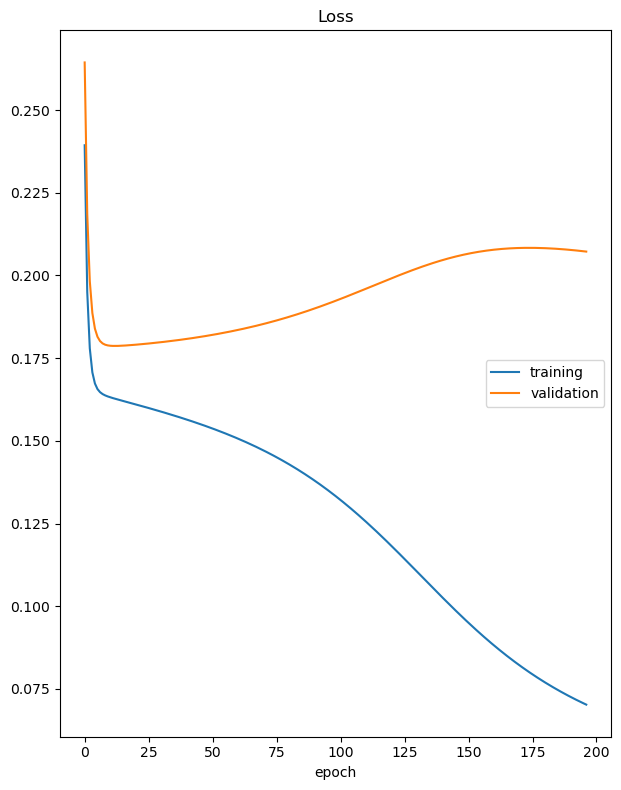

Loss
	training         	 (min:    0.070, max:    0.239, cur:    0.070)
	validation       	 (min:    0.179, max:    0.264, cur:    0.207)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NetflixRecommender,0.045146,0.12186,0.164291,0.229124,0.045146,0.088881,0.106604,0.127288


In [41]:
from recommenders.netflix_recommender import NetflixRecommender

netflix_recommender = NetflixRecommender(embedding_dim=8, n_epochs=200, print_type='live')

netflix_tts_results = [['NetflixRecommender'] + list(evaluate_train_test_split_implicit(
    netflix_recommender, interactions_df, items_df))]

netflix_tts_results = pd.DataFrame(
    netflix_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(netflix_tts_results.to_html()))

In [42]:
tts_results = pd.concat([nn_tts_results, amazon_tts_results, netflix_tts_results]).reset_index(drop=True)
display(HTML(tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.058384,0.116768,0.165648,0.263747,0.058384,0.092865,0.113277,0.145123
1,AmazonRecommender,0.044128,0.118805,0.160557,0.223693,0.044128,0.086755,0.104216,0.124468
2,NetflixRecommender,0.045146,0.121860,0.164291,0.229124,0.045146,0.088881,0.106604,0.127288


# Summary

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Write a summary of your experiments. What worked well and what did not? What are your thoughts how could you possibly further improve the model?

In [ ]:
# To complete this project I used user and item features developed in project 1. Then I created a simple neural network which
# consists of 2 layers and ReLU as activation function. To NNRecommender class I:
# 1. added some arguments (epochs, batch_size, drop_out, learning_rate, neurons), 
# 2. coded fit and recommend methods mostly the same way as in project 1 with neural network parts, 
# 3. used Adam optimizer.
# With those steps I managed to get some recommendations and after tuning selected arguments I got HR@10: 0.263747

# I tried to use more complex neural network with 4 layers, ReLU activation function and dropout layer but the results
# were significantly worse (HR@10: 0.16~0.17). I also tried to use different optimizers like Adagrad or SGD to both networks.
# The results were also a little worse so I decided to stick with Adam and simple neural network. To improve this model
# I guess that I could experiment with embedding layers, add additional arguments or try different algorithms presented during
# this class. Nonetheless I think that I managed to get a good final result that is much better than the one from
# my previous recommender which achieved HR@10: 0.239308